In [42]:
import collections
import statistics
from typing import Iterator, List, Tuple

import matplotlib.pyplot as plt
import nest_asyncio
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
from plotnine import *
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate

# Table of Contents

- [Step 1](#Step-1)
- [Step 2](#Step-2-+-Step-3)
- [Step 3](#Step-2-+-Step-3)
- [Step 4](#Step-4)
- [Step 5](#Step-5)
- [Step 6](#Step-6)
- [Step 7](#Step-4)
- [Step 8](#Step-5)
- [Step 9](#Step-6)
- [Step 10](#Step-10)

In [3]:
def inspect_df(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """Helper method to easily inspect DataFrames."""

    print(f"shape: {df.shape}")

    return df.head(n)

In [4]:
# dataset source: https://grouplens.org/datasets/movielens/
!wget --backups=1 https://files.grouplens.org/datasets/movielens/ml-latest-small.zip -P data/

--2022-03-19 11:01:48--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘data/ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K   391KB/s    in 2.4s    

2022-03-19 11:01:51 (391 KB/s) - ‘data/ml-latest-small.zip’ saved [978202/978202]



In [5]:
# if `unzip` does not exist in your system: apt-get install unzip
!unzip -o data/ml-latest-small.zip -d data/

Archive:  data/ml-latest-small.zip
  inflating: data/ml-latest-small/links.csv  
  inflating: data/ml-latest-small/tags.csv  
  inflating: data/ml-latest-small/ratings.csv  
  inflating: data/ml-latest-small/README.txt  
  inflating: data/ml-latest-small/movies.csv  


## Step 1

In [6]:
# Formulate the optimization problem (similarly to the formulation in Unit 5). Your
# optimization problem will relate to the prediction error in the training dataset.
# Make sure you understand the unknowns of the problem, and what you are trying to optimize.

## Step 2 + Step 3

In [7]:
reader = Reader(
    line_format="user item rating timestamp", sep=",", skip_lines=1, rating_scale=(1, 5)
)

In [8]:
data = Dataset.load_from_file("data/ml-latest-small/ratings.csv", reader=reader)

## Step 4

In [9]:
recsys_small = SVD(
    n_factors=4,
    n_epochs=50,
    biased=True,  # use baselines
    random_state=123456,
)

In [10]:
recsys_large = SVD(
    n_factors=20,
    n_epochs=50,
    biased=True,  # use baselines
    random_state=123456,
)

In [11]:
cv_results = {}

cv_results["SVD w/ 4 factors"] = cross_validate(
    recsys_small,
    data=data,
    measures=["mse", "rmse", "mae"],
    return_train_measures=True,
    verbose=True,
    cv=5,
    n_jobs=-1,
)

Evaluating MSE, RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MSE (testset)     0.7770  0.7617  0.7722  0.7573  0.7638  0.7664  0.0072  
RMSE (testset)    0.8815  0.8728  0.8788  0.8703  0.8739  0.8754  0.0041  
MAE (testset)     0.6737  0.6668  0.6690  0.6674  0.6696  0.6693  0.0024  
MSE (trainset)    0.5148  0.5113  0.5128  0.5153  0.5109  0.5130  0.0018  
RMSE (trainset)   0.7175  0.7150  0.7161  0.7178  0.7148  0.7162  0.0012  
MAE (trainset)    0.5516  0.5497  0.5513  0.5522  0.5494  0.5508  0.0011  
Fit time          1.56    1.55    1.61    1.53    1.54    1.56    0.03    
Test time         0.09    0.09    0.09    0.09    0.09    0.09    0.00    


In [12]:
cv_results["SVD w/ 20 factors"] = cross_validate(
    recsys_large,
    data=data,
    measures=["mse", "rmse", "mae"],
    return_train_measures=True,
    verbose=True,
    cv=5,
    n_jobs=-1,
)

Evaluating MSE, RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MSE (testset)     0.7873  0.7731  0.7704  0.7893  0.7799  0.7800  0.0075  
RMSE (testset)    0.8873  0.8793  0.8777  0.8884  0.8831  0.8832  0.0042  
MAE (testset)     0.6796  0.6688  0.6707  0.6821  0.6751  0.6753  0.0051  
MSE (trainset)    0.3012  0.3024  0.2977  0.3015  0.3025  0.3010  0.0018  
RMSE (trainset)   0.5488  0.5499  0.5456  0.5491  0.5500  0.5487  0.0016  
MAE (trainset)    0.4229  0.4249  0.4214  0.4245  0.4243  0.4236  0.0013  
Fit time          3.08    3.01    3.01    2.98    3.04    3.02    0.03    
Test time         0.10    0.10    0.13    0.11    0.11    0.11    0.01    


In [13]:
df = pd.DataFrame(cv_results).T.reset_index()

df["mean RMSE (train)"] = df["train_rmse"].map(lambda x: statistics.mean(x))

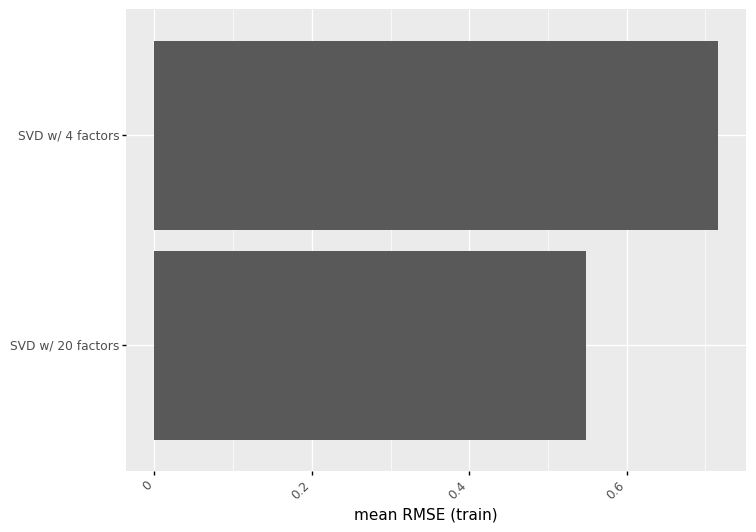

<ggplot: (8751012044508)>

In [14]:
(
    ggplot(df)
    + geom_col(aes(x="index", y="mean RMSE (train)"), stat="identity")
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(8, 6))
    + labs(x="", y="mean RMSE (train)")
    + coord_flip()
)

## Step 5

In [15]:
ratings = pd.read_csv(
    "data/ml-latest-small/ratings.csv",
    usecols=["user", "item", "rating"],
    names=["user", "item", "rating"],
    skiprows=1,
)

inspect_df(ratings)

shape: (100836, 3)


,user,item,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [16]:
ratings["user"] = ratings.groupby("user").ngroup()

In [17]:
ratings["item"] = ratings.groupby("item").ngroup()

In [18]:
def create_tf_datasets(
    data: pd.DataFrame,
    batch_size: int = 1,
    max_clients: int = None,
    max_items_per_client: int = None,
) -> Iterator[tf.data.Dataset]:

    n_users = len(data["user"].unique())

    if max_clients is not None:
        n_users = min(n_users, max_clients)

    def transform_batch(batch: tf.Tensor) -> collections.OrderedDict:

        return collections.OrderedDict(
            x=tf.cast(batch[:, 0:2], tf.int64), y=tf.cast(batch[:, 2:3], tf.float32)
        )

    for _, user_ratings in data.groupby("user"):

        if n_users < 0:
            break

        tf_dataset = tf.data.Dataset.from_tensor_slices(user_ratings)

        yield (
            tf_dataset.take(max_items_per_client)
            .shuffle(buffer_size=max_items_per_client, seed=42)
            .batch(batch_size)
            .map(transform_batch, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        )

        n_users -= 1

In [19]:
def split_tf_datasets(
    tf_datasets: List[tf.data.Dataset],
    train_fraction: float = 0.8,
    val_fraction: float = 0.1,
) -> Tuple[List[tf.data.Dataset], List[tf.data.Dataset], List[tf.data.Dataset]]:
    """Splits a list of user TF datasets into train/val/test by user."""
    np.random.seed(42)
    np.random.shuffle(tf_datasets)

    train_idx = int(len(tf_datasets) * train_fraction)
    val_idx = int(len(tf_datasets) * (train_fraction + val_fraction))

    # Note that the val and test data contains completely different users, not
    # just unseen ratings from train users.
    return (
        tf_datasets[:train_idx],
        tf_datasets[train_idx:val_idx],
        tf_datasets[val_idx:],
    )

In [20]:
tf_datasets = [
    *create_tf_datasets(
        data=ratings,
        batch_size=5,
        max_clients=100,
        max_items_per_client=3000,
    )
]

In [21]:
tf_trainsets, tf_validationsets, tf_testsets = split_tf_datasets(
    tf_datasets, train_fraction=0.8, val_fraction=0.1
)

## Step 6

In [23]:
nest_asyncio.apply()

In [30]:
n_users = len(ratings["user"].unique())
n_items = len(ratings["item"].unique())

In [31]:
def matrix_factorization_model(
    n_users: int,
    n_items: int,
    n_latent_factors: int,
) -> tf.keras.Model:
    """A federation-friendly Matrix Factorization model."""
    combined_input = tf.keras.layers.Input(
        shape=[2], dtype="int32", name="combined_input"
    )
    u = tf.keras.layers.Embedding(
        input_dim=n_users + 1, output_dim=n_latent_factors, name="users_embedding"
    )(combined_input[:, 0])
    u = tf.keras.layers.Flatten()(u)

    i = tf.keras.layers.Embedding(
        input_dim=n_items + 1, output_dim=n_latent_factors, name="items_embedding"
    )(combined_input[:, 1])
    i = tf.keras.layers.Flatten()(i)

    output = tf.output_layer = tf.keras.layers.Dot(1, normalize=False, name="Dot")(
        [i, u]
    )

    return tf.keras.Model(inputs=combined_input, outputs=output)

In [32]:
def model_fn():
    model = matrix_factorization_model(
        n_users=n_users,
        n_items=n_items,
        n_latent_factors=20,
    )

    input_spec = collections.OrderedDict(
        x=tf.TensorSpec(shape=[None, 2], dtype=tf.int64),
        y=tf.TensorSpec(shape=[None, 1], dtype=tf.float32),
    )

    return tff.learning.from_keras_model(
        model,
        input_spec=input_spec,
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )

In [33]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0),
)

In [34]:
str(iterative_process.initialize.type_signature)

'( -> <model=<trainable=<float32[9725,20],float32[611,20]>,non_trainable=<>>,optimizer_state=<int64>,delta_aggregate_state=<value_sum_process=<>,weight_sum_process=<>>,model_broadcast_state=<>>@SERVER)'

In [35]:
state = iterative_process.initialize()

print(state.model)

ModelWeights(trainable=[array([[ 0.00449531, -0.00261959, -0.00832176, ..., -0.02959056,
        -0.01731151, -0.00890594],
       [ 0.00254009,  0.01087872,  0.00375149, ...,  0.01110788,
        -0.003428  , -0.01929864],
       [-0.04495741,  0.02589368,  0.03868851, ...,  0.04061517,
         0.03942777, -0.03821265],
       ...,
       [ 0.03911779, -0.00377908, -0.01929331, ..., -0.0455562 ,
         0.03307593,  0.04017692],
       [ 0.03798349, -0.00108527, -0.02169795, ..., -0.02899946,
         0.02521763,  0.04309293],
       [ 0.03123071, -0.0343964 ,  0.00554594, ..., -0.04396687,
         0.00045417, -0.03207802]], dtype=float32), array([[ 0.01219307, -0.01272322,  0.01501726, ..., -0.01826163,
        -0.0257524 , -0.02350754],
       [-0.00827932, -0.04239985,  0.03963881, ...,  0.03283193,
         0.04460869,  0.00797957],
       [-0.01271596,  0.03416767,  0.0261735 , ..., -0.00777305,
         0.04715302,  0.0031972 ],
       ...,
       [ 0.03180457, -0.04895198, -

In [38]:
print("User variables shape:", state.model.trainable[1].shape)

User variables shape: (611, 20)


In [37]:
print("Item variables shape:", state.model.trainable[0].shape)

Item variables shape: (9725, 20)


In [39]:
evaluation_computation = tff.learning.build_federated_evaluation(model_fn)

In [40]:
NUM_ROUNDS = 30

train_losses, train_accs = [], []

state = iterative_process.initialize()

for i in range(NUM_ROUNDS):
    federated_train_data = np.random.choice(
        tf_trainsets, size=50, replace=False
    ).tolist()
    state, metrics = iterative_process.next(state, federated_train_data)
    print(f"Train round {i}:", metrics["train"])
    train_losses.append(metrics["train"]["loss"])
    train_accs.append(metrics["train"]["root_mean_squared_error"])

Train round 0: OrderedDict([('root_mean_squared_error', 3.659201), ('loss', 13.389752), ('num_examples', 8644), ('num_batches', 1751)])
Train round 1: OrderedDict([('root_mean_squared_error', 3.6203878), ('loss', 13.107207), ('num_examples', 8908), ('num_batches', 1806)])
Train round 2: OrderedDict([('root_mean_squared_error', 3.6475377), ('loss', 13.304531), ('num_examples', 9100), ('num_batches', 1842)])
Train round 3: OrderedDict([('root_mean_squared_error', 3.6927018), ('loss', 13.636047), ('num_examples', 7853), ('num_batches', 1595)])
Train round 4: OrderedDict([('root_mean_squared_error', 3.6221838), ('loss', 13.120215), ('num_examples', 9232), ('num_batches', 1867)])
Train round 5: OrderedDict([('root_mean_squared_error', 3.682055), ('loss', 13.5575285), ('num_examples', 8628), ('num_batches', 1749)])
Train round 6: OrderedDict([('root_mean_squared_error', 3.714388), ('loss', 13.796678), ('num_examples', 9198), ('num_batches', 1861)])
Train round 7: OrderedDict([('root_mean_squ

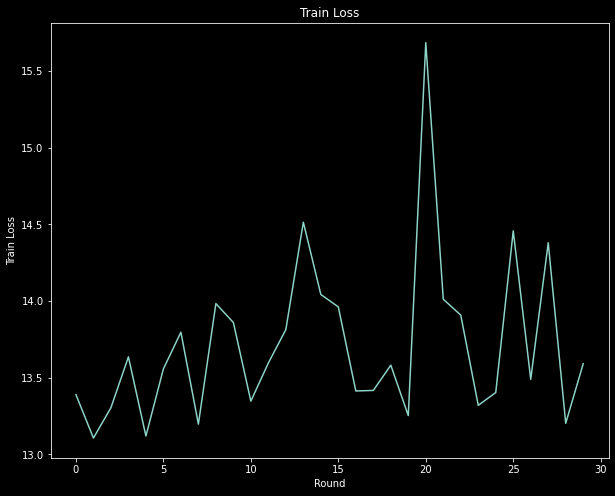

In [43]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(range(NUM_ROUNDS), train_losses)
plt.ylabel("Train Loss")
plt.xlabel("Round")
plt.title("Train Loss")
plt.show()

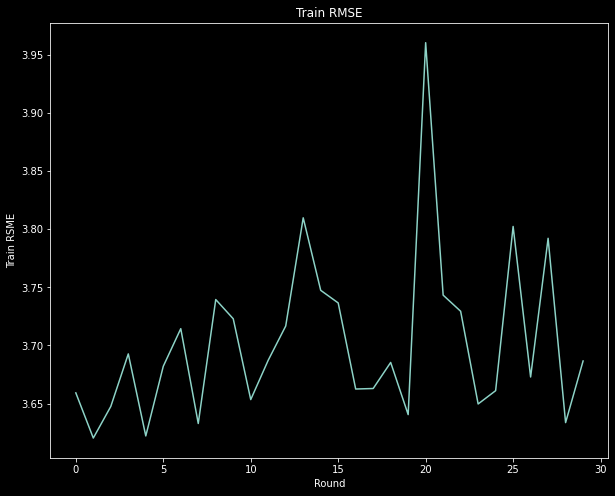

In [44]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(range(NUM_ROUNDS), train_accs)
plt.ylabel("Train RSME")
plt.xlabel("Round")
plt.title("Train RMSE")
plt.show()

In [45]:
eval_metrics = evaluation_computation(state.model, tf_validationsets)
print("Final Eval:", eval_metrics["eval"])

Final Eval: OrderedDict([('root_mean_squared_error', 3.757149), ('loss', 14.116168), ('num_examples', 1038), ('num_batches', 210)])


In [46]:
eval_metrics = evaluation_computation(state.model, tf_testsets)
print("Final Test:", eval_metrics["eval"])

Final Test: OrderedDict([('root_mean_squared_error', 3.807275), ('loss', 14.495344), ('num_examples', 1301), ('num_batches', 264)])


## Step 7

## Step 8

## Step 9

## Step 10